### Installation using conda for "quantstats" library
$ conda install -c ranaroussi quantstats

! pip install quantstats

### Import library and fetching data

In [1]:
%matplotlib inline
import quantstats as qs

import pandas as pd
import hvplot.pandas
import yfinance as yf
from dotenv import load_dotenv
import numpy as np

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

### Visualize stock performance

In [2]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from panel.interact import interact

In [3]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [4]:
from panel.interact import interact, interactive, fixed, interact_manual
from panel import widgets
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
pn.extension()

In [5]:
import pickle
with open("tickers.pickle", "rb") as f:
    # Get a list of all tickers
    ticker_list = pickle.load(f)

In [6]:
from tkinter import *

OPTIONS = ticker_list

master = Tk()

variable = StringVar(master)
variable.set(OPTIONS[0]) # default value

w = OptionMenu(master, variable, *OPTIONS)
w.pack()

def ok():
    my_ticker=variable.get()
    print("The selected ticker is: "+ my_ticker)
    
button = Button(master, text="OK", command=ok)
button.pack()

mainloop()

# Get the input from users
my_ticker=variable.get()
my_ticker

The selected ticker is: V


'V'

In [7]:
my_ticker

'V'

In [8]:
def search(list, ticker):
    for i in range(len(list)):
        if list[i] == ticker:
            return True
    return False

ticker = my_ticker
if search(ticker_list, ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="5y")
    stock_df = pd.DataFrame()
    stock_df[ticker] = hist["Close"]
    last_closin_price=stock_df[ticker].tail(1).values.tolist()    
    
    print(f' {ticker} last stock close price is ${round(last_closin_price[0], 2)}')
else:
    print(f' {ticker} last stock close price is not available')

 V last stock close price is $201.59


### Tab 1 Historical stock price visualization

In [9]:
# Define interactive stock price for specific ticker symbol- tab 1
def price_graph():
    window_size=['5d','1mo','3mo','6mo','1y','2y','5y','10y','ytd','max']

    def vizual(window_size,my_ticker):
        """ Return stock price grapgh for the last 5 years"""
        stock_visual = yf.Ticker(my_ticker)
        hist = stock_visual.history(period=window_size)

        # Create an empty DataFrame for closing prices
        data_stock = pd.DataFrame()

        # Fetch the closing prices
        data_stock[stock_visual] = hist["Close"]

        return data_stock.hvplot(title = "Stock performance over time")
        
    return (interact(vizual, my_ticker=ticker,window_size=window_size))
window_size=['1d','5d','1mo','3mo','6mo','1y','2y','5y','10y','ytd','max']
interactive_period ="Please choose the desire period"
interact = pn.interact(price_graph, window_size= window_size)

In [225]:
import plotly.figure_factory as ff

In [242]:
def display_info(ticker):
    Yahoo_ticker = yf.Ticker(ticker)
    # info table
    info=Yahoo_ticker.info
    # convert dict to dataframe
    info_df=pd.DataFrame(info.items(), columns=['Information', 'Value'])
    #reset index
    info_df=info_df.set_index("Information")
    # retrieve specific info we want to display
    info_display_df=info_df.loc[["dividendYield", "trailingAnnualDividendRate", "profitMargins","forwardEps", "52WeekChange", "fiftyTwoWeekHigh", "fiftyTwoWeekLow",
                                 "averageVolume10days", "exchange"
                                 
                                 
                                 ]]
    #index=['Dividend Yield', 'Profit Margins', '52 Week Change', "52 Week High", "52 Week Low","Forward EPS"]
    info_display_df=info_display_df.rename(index={
        "dividendYield":'Dividend Yield',
        "trailingAnnualDividendRate":"Trailing Annual Dividend Yield",
        "profitMargins": 'Profit Margins', 
        "forwardEps":"Forward EPS",
        "52WeekChange":'52 Week Change',
        "fiftyTwoWeekHigh": "52 Week High",
        "fiftyTwoWeekLow":"52 Week Low",
        
        "averageVolume10day":"Average Trading Volume 10 day",
        
        "exchange":"Exchange",
        
    })
    
    return info_display_df


def display_business_summary(ticker):
    Yahoo_ticker = yf.Ticker(ticker)
    print (f'Sector Info:\n {Yahoo_ticker.info["sector"]}\n') 
    print (f'Industry Info:\n {Yahoo_ticker.info["industry"]}\n') 
    print(f'Business Summary:\n {Yahoo_ticker.info["longBusinessSummary"]}')

In [243]:
#display_info(ticker)

### Tab 2 Return and volatility metrics

In [44]:
# Get benchmark data of S&P 500 and Nasdaq ^IXIC for previous 5 years
index_sp500_stock = yf.Ticker("^GSPC")
index_nasdaq_stock= yf.Ticker("^IXIC")
index_hist_sp500_stock = index_sp500_stock.history(period="5y")
index_hist_nasdaq_stock = index_nasdaq_stock.history(period="5y")

# Create an empty DataFrame for closing prices
index_df = pd.DataFrame()

# Fetch the closing prices
index_df["S&P500"] = index_hist_sp500_stock["Close"]
index_df["NASDAQ"] = index_hist_nasdaq_stock["Close"]
#Display 
#index_df.tail()

In [54]:
def daily_return_graph():
    # Combine 2 individual stock price and index benchmark dataframe
    df_daily = pd.concat([stock_df, index_df], axis = "columns",join = "inner")
    # Calculate Daily Returns
    daily_returns = df_daily.pct_change().dropna()
    daily_returns.head()
    
    
    # Calculate cumulative returns
    cum_returns = (1+ daily_returns).cumprod()
    return daily_returns.hvplot(title = "Daily return for ticker " + ticker)

In [70]:
def daily_cum_return_graph():
    # Calculate cumulative returns
    cum_returns = (1+ daily_returns).cumprod()
    return cum_returns.hvplot(title = "Cumulative return for ticker " + ticker,
                             attr_labels = True)

In [175]:
def sharpe_graph():
    # Calculate sharpe ratio
    
    # Annualized Sharpe Ratios
    sharpe_ratios = daily_returns.mean()*252/(df_daily.std()*np.sqrt(252))
    # In percentage
    sharpe_ratios= sharpe_ratios*100
    # Visualize the sharpe ratios as a bar plot
    return sharpe_ratios.hvplot(title = "Sharpe ratios for ticker " + ticker + " and the benchmark",
                                kind = "bar",
                                hover_color = "orange",
                                 attr_labels = True)

In [150]:
# Define rolling standard deviation for specific ticker symbol- tab 2
def rolling_visual(window_size):
    """ Return rolling standard deviation grapgh for periods"""

    # Calculate the rolling standard deviation for investment using a specified window
    rolloing_std_df= daily_returns.rolling(window = window_size).std().dropna()
    rolloing_std_df=(rolloing_std_df*100).round(1)
    
    return rolloing_std_df.hvplot(title = "Rolling standard deviation for ticker " + ticker + " in a "+ str(window_size) +"-day window",
                         attr_labels = True,
                        ylabel= "in %"
                           )
        

In [153]:
# Define rolling ewm for specific ticker symbol- tab 2
def rolling_visual_ewm(window_size):
    """ Return rolling standard deviation grapgh for periods"""

    # Calculate the rolling ewm for investment using a specified window
    df_daily_ewm = daily_returns.ewm(halflife =window_size).std().dropna()
    df_daily_ewm=(df_daily_ewm*100).round(1)
    
    return df_daily_ewm.hvplot(title = "Rolling standard deviation for ticker " + ticker + " in a "+ str(window_size) +"-day window",
                         attr_labels = True,
                        ylabel= "in %"
                           )

### Tab 3 Algo Trading Strategy - exit and entry points

### Create a dashboard

In [244]:
# Create a Title for the Dashboard
title = "# Dashboard for your potential investments"

# Define a welcome text
welcome_text= "#### This dashboard presents a visual analysis of investment performance."
# info_text= display_business_summary(stock)

# Create a tab layout for the dashboard
welcome_tab = pn.Column(welcome_text,
                        pn.Column(interactive_period, interact[1], display_info(ticker))
                       )
return_text = "#### A brief snapshot of return and volatility over the past 5 years"
return_analysis = pn.Column(return_text,
                        pn.Row(daily_cum_return_graph(), sharpe_graph()),
                        pn.Row(rolling_visual(30),rolling_visual(60)),
                        pn.Row(rolling_visual_ewm(30),rolling_visual_ewm(60)),    
    
                           )

In [245]:
dashboard = pn.Column(
    title, pn.Tabs(
        (
            "Welcome",
            welcome_tab
        ),
        (
            "Return and volatility metrics",
            return_analysis
        ),

  
))

dashboard

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Column
                [0] Markdown(str)
                [1] Row
                    [0] Column
                        [0] Column
                            [0] Select(name='window_size', options=['5d', '1mo', ...], value='5y')
                            [1] TextInput(name='my_ticker', value='V')
                        [1] Row
                            [0] HoloViews(Curve, name='interactive01454')
                [2] DataFrame(DataFrame)
        [1] Column
            [0] Markdown(str)
            [1] Row
                [0] HoloViews(NdOverlay)
                [1] HoloViews(Bars)
            [2] Row
                [0] HoloViews(NdOverlay)
                [1] HoloViews(NdOverlay)
            [3] Row
                [0] HoloViews(NdOverlay)
                [1] HoloViews(NdOverlay)

In [69]:
###volumne! trading

### Others - other graphs and metric with new library

In [197]:
%matplotlib inline
import quantstats as qs
# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [198]:
# fetch the daily returns for a stock
stock_qs = qs.utils.download_returns(ticker)

                    Strategy
------------------  ----------
Start Period        2008-03-19
End Period          2021-01-15
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   1,462.53%
CAGR%               23.88%
Sharpe              0.86
Sortino             1.27
Max Drawdown        -51.9%
Longest DD Days     589

Payoff Ratio        0.99
Profit Factor       1.18
Common Sense Ratio  1.21
CPC Index           0.63
Tail Ratio          1.03
Outlier Win Ratio   4.44
Outlier Loss Ratio  3.95

MTD                 -7.84%
3M                  -0.15%
6M                  2.87%
YTD                 -7.84%
1Y                  1.52%
3Y (ann.)           19.61%
5Y (ann.)           23.11%
10Y (ann.)          28.43%
All-time (ann.)     23.88%

Avg. Drawdown       -3.23%
Avg. Drawdown Days  24
Recovery Factor     28.18
Ulcer Index         1.0


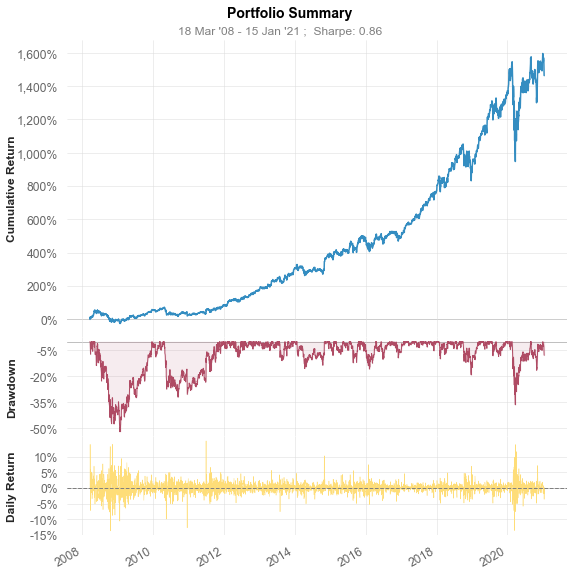

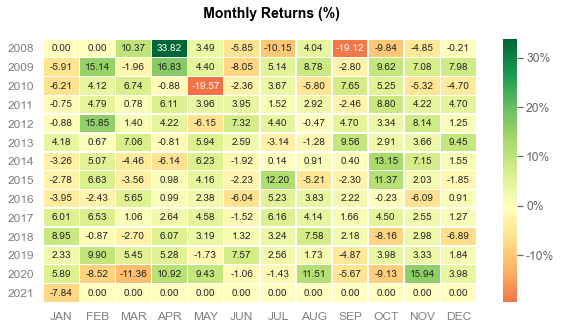

In [199]:
# Create a basic metric report
qs.reports.basic(stock_qs)

In [18]:
# Define function for specific ticker symbol- tab 2
def monthly_heatmap(qs_symbol):
    """Monthly Return Graph"""
    monthly_heatmap_fig= qs.plots.monthly_heatmap(qs_symbol)
    return monthly_heatmap_fig
def distribution(qs_symbol):
    """ Return Quantiles"""
    distribution_fig=qs.plots.distribution(qs_symbol)
    return distribution_fig
def rolling_beta(qs_symbol):
    """ Return rolling beta 6 month"""
    rolling_beta_fig= qs.plots.rolling_beta(qs_symbol, "SPY")
    return rolling_beta_fig
def rolling_volatility(qs_symbol):
    """ Return rolling volatility 6 month"""
    rolling_volatility_fig=qs.plots.rolling_volatility(qs_symbol)
    return rolling_volatility_fig

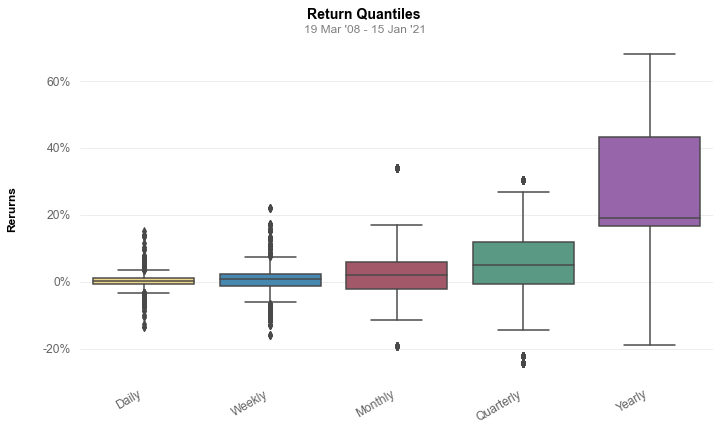

In [200]:
distribution(stock_qs)

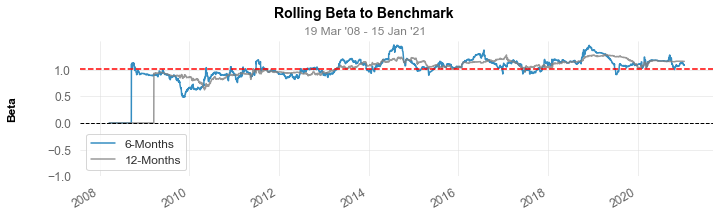

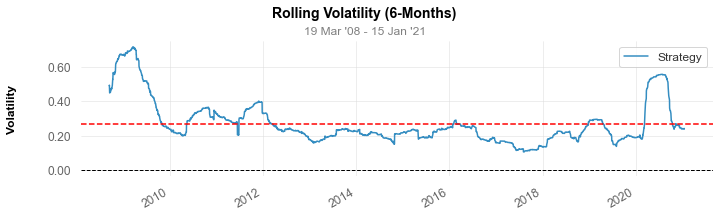

In [201]:
rolling_beta(stock_qs) 
rolling_volatility(stock_qs)

### Reference

1. https://github.com/ranaroussi/quantstats
2. Dash